In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
import preprocessing
import training
import testing
import importlib

importlib.reload(preprocessing)
importlib.reload(training)
importlib.reload(testing)

print('Loaded Libraries')

Loaded Libraries


In [4]:
# Customized CNN Model
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(10, 15, kernel_size=3)
        self.fc1 = torch.nn.Linear(375, 50)
        self.fc2 = torch.nn.Linear(50, 10)
        
    def forward(self, x):
        # 28 X 28 --> 26 X 26 --> 13 X 13
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        # 13 X 13 --> 11 X 11 --> 5 X 5
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # 5 X 5 X 15
        x = x.view(-1, 375)
        x = self.fc1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# Define CNN model
model_ft = Model()

if torch.cuda.is_available():
    model_ft.cuda()

# Define image data transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])
])


# Load data
valid_fraction = 0.1

train_file = pd.read_csv('./digit-recognizer/train.csv')
# convert dataframe of pandas into numpy array
train_file = train_file.to_numpy().astype('uint8')

boundary = int(len(train_file) * (1 - valid_fraction))

train_data = preprocessing.DigitDataset(train_file[:boundary], transforms, phase='training')
valid_data = preprocessing.DigitDataset(train_file[boundary:], transforms, phase='training')

train_data_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 3
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 3
)

datasets = {'train' : train_data_loader, 'valid' : valid_data_loader}
datasets_size = {'train' : len(train_data_loader.dataset), 'valid' : len(valid_data_loader.dataset)}

In [4]:
# It was meaningless that to set 'epochs' value over 20
epochs = 20
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001)
scheduler_ft = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7)

In [ ]:
train_loss, valid_loss = training.training(model_ft, datasets, datasets_size, optimizer_ft, scheduler_ft, epochs=epochs)

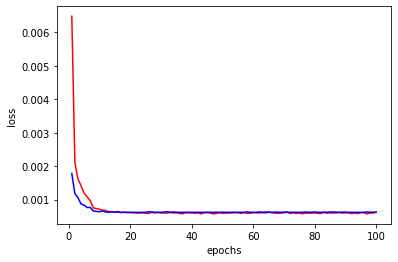

In [6]:
# Draw loss graph for training
epoch_x = range(1, epochs + 1)
plt.plot(epoch_x, train_loss, 'r', epoch_x, valid_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [7]:
# Load test dataset
test_file = pd.read_csv('./digit-recognizer/test.csv')
test_file = test_file.to_numpy().astype('uint8')

test_data = preprocessing.DigitDataset(test_file, transforms, phase='testing')

test_data_loader = DataLoader(
    test_data,
    batch_size = 16,
    num_workers = 3
)

In [8]:
# Load best model
model_ft = Model()
model_ft.load_state_dict(torch.load('final_model.pth'))

if torch.cuda.is_available():
    model_ft.cuda()

# Test the model
result = testing.testing(model_ft, test_data_loader)

In [9]:
# Export result as csv file in form of Kaggle
submission = pd.DataFrame({
    'ImageId' : range(1, len(result) + 1),
    'Label' : result
},columns=['ImageId', 'Label'])
submission.to_csv('submission.csv', index=False)